### Examine the Data

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [308]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [309]:
len(df)

15001

### Plot the source data

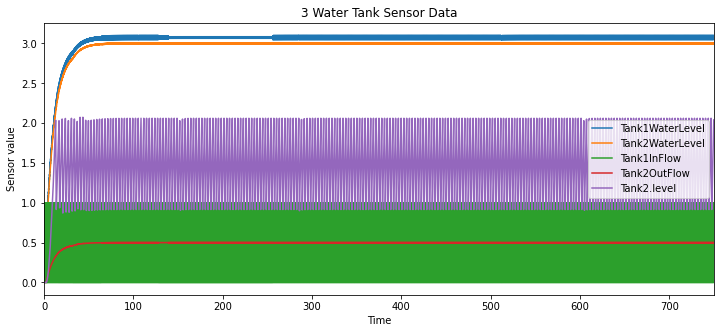

In [310]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [311]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [312]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [313]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [314]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
#     return pd.DataFrame(normalised_data), means, stds
    return pd.DataFrame(normalised_data)


# def normalise_timeseries(data):
# #     mini = np.min(data)
#     mini = data.min(axis=0)
#     maxi = data.max(axis=0)
#     return (data - mini)/(maxi - mini)



def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


time_series_data = np.array([[1,2,3],[4,5,6],[7,8,9]])

# normalised_data, means, stds = normalise_timeseries(time_series_data)

# normalised_data, means, stds = normalise_timeseries(df)
normalised_data = normalise_timeseries(df)

# print("---------------Original data---------------")
# print(time_series_data)
# print("---------------Normalised data---------------")
# print(normalised_data)
# print("---------------Original data---------------")
# print(denormalise_timeseries(normalised_data, means, stds))

In [315]:
df = normalised_data

In [353]:
my_df = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
my_df.index.freq = 'MS'
print(np.std(my_df))

Tank1WaterLevel    0.254335
Tank2WaterLevel    0.250147
Tank1InFlow        0.499999
Tank2OutFlow       0.048456
wt3_valve          0.434418
Tank3OutFlow       0.852766
Tank2.level        0.358990
dtype: float64


In [317]:
# # Train Test Split
# nobs = 3000
# train = df.iloc[:-nobs]
# test = df.iloc[-nobs:]
# len(train), len(test)

In [318]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-11.918320,-11.820661,-1.001802,-10.143714,-0.581122,-0.560669,-4.024580
0.05,-11.918321,-11.820660,-1.001802,-10.143714,-0.581122,-0.560669,-4.024580
0.10,-11.905215,-11.820660,0.998202,-10.143714,-0.581122,-0.560669,-4.024580
0.15,-11.704101,-11.785282,0.998202,-10.143714,-0.581122,-0.560669,-4.024580
0.20,-11.614902,-11.702742,-1.001802,-10.143714,-0.581122,-0.560669,-4.024580
...,...,...,...,...,...,...,...
749.80,0.241088,0.188868,-1.001802,0.181158,-0.581122,-0.560669,1.382379
749.85,0.157189,0.194102,-1.001802,0.196210,-0.581122,-0.560669,1.438112
749.90,0.065612,0.167090,-1.001802,0.180843,-0.581122,-0.560669,1.521845


In [319]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [320]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -43.61023435314222
BIC: -43.57573526414129

VAR Order 2
AIC: -48.65257053107074
BIC: -48.58788007751992

VAR Order 3
AIC: -51.8512160792599
BIC: -51.75632990921282

VAR Order 4
AIC: -54.752996193450116
BIC: -54.627909953957285

VAR Order 5
AIC: -56.23274870050805
BIC: -56.0774580376165

VAR Order 6
AIC: -57.33026722323206
BIC: -57.144767781985095

VAR Order 7
AIC: -58.362379749552304
BIC: -58.14666717398911

VAR Order 8
AIC: -58.726840470274
BIC: -58.480910403429384

VAR Order 9
AIC: -59.26419446859687
BIC: -58.98804255250093

VAR Order 10
AIC: -60.97832248319695
BIC: -60.67194435887474

VAR Order 11
AIC: -61.45996058103744
BIC: -61.12335188850869

VAR Order 12
AIC: -62.38079238126353
BIC: -62.01394875954228

VAR Order 13
AIC: -62.83918300834727
BIC: -62.4421000954416

VAR Order 14
AIC: -63.649002535206435
BIC: -63.22167596811813

VAR Order 15
AIC: -64.09891217694545
BIC: -63.641337591669675

VAR Order 16
AIC: -64.90329852056706
BIC: -64.41547155209204

VAR Order 17
AI

In [321]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [322]:
min_aic_index

19

In [323]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jun, 2023
Time:                     16:23:14
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -66.5238
Nobs:                     11982.0    HQIC:                  -66.9083
Log likelihood:           283936.    FPE:                7.20803e-30
AIC:                     -67.1024    Det(Omega_mle):     6.66817e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003428         0.000228          -15.039           0.000
L1.Tank1WaterLevel          0.331329         0.010402           31.852           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [324]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [325]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,-11.918320,-11.820661,-1.001802,-10.143714,-0.581122,-0.560669,-4.02458
0.05,-11.918321,-11.820660,-1.001802,-10.143714,-0.581122,-0.560669,-4.02458
0.10,-11.905215,-11.820660,0.998202,-10.143714,-0.581122,-0.560669,-4.02458
0.15,-11.704101,-11.785282,0.998202,-10.143714,-0.581122,-0.560669,-4.02458
0.20,-11.614902,-11.702742,-1.001802,-10.143714,-0.581122,-0.560669,-4.02458


In [326]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.24108689,  0.18894335, -1.00406281,  0.18121058, -0.69040171,
        -0.56135418, -0.03597168],
       [ 0.12339003,  0.18848384, -1.00346457,  0.19551539, -0.74891104,
        -0.71365215,  0.0592202 ],
       [ 0.06581696,  0.16703672, -0.9848027 ,  0.18076057, -0.80241683,
        -0.783614  ,  0.14844658],
       [ 0.18700797,  0.15055612,  0.99953579,  0.15371465, -0.8153265 ,
        -0.8495507 ,  0.25749487],
       [ 0.25153949,  0.16567555,  0.99242481,  0.15994511, -0.82463751,
        -0.84768477,  0.35851039],
       [ 0.19590271,  0.19489469, -1.00251006,  0.19131315, -0.81280569,
        -0.85031816,  0.46518262],
       [ 0.12282555,  0.18841564, -1.00497244,  0.19545728, -0.79102701,
        -0.81374076,  0.56521016],
       [ 0.10329437,  0.15584768,  0.99237779,  0.16876447, -0.74619251,
        -0.77591667,  0.66167523],
       [ 0.18776948,  0.15069184,  0.99203544,  0.15374198, -0.69514672,
        -0.69333484,  0.74957603],
       [ 0.27810151,  0.1776

In [327]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,0.241087,0.188867,-1.001802,0.181157,-0.581122,-0.560669,-0.038262
600.10,0.123358,0.188439,-1.001802,0.195506,-0.581122,-0.560669,0.045346
600.15,0.065611,0.167089,-1.001802,0.180842,-0.581122,-0.560669,0.101162
600.20,0.186895,0.150496,0.998202,0.153725,-0.581122,-0.560669,0.184784
600.25,0.250944,0.165479,0.998202,0.159884,-0.581122,-0.560669,0.240394
...,...,...,...,...,...,...,...
749.80,0.241088,0.188868,-1.001802,0.181158,-0.581122,-0.560669,1.382379
749.85,0.157189,0.194102,-1.001802,0.196210,-0.581122,-0.560669,1.438112
749.90,0.065612,0.167090,-1.001802,0.180843,-0.581122,-0.560669,1.521845


In [328]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.241087,0.188943,-1.004063,0.181211,-0.690402,-0.561354,-0.035972
1,0.123390,0.188484,-1.003465,0.195515,-0.748911,-0.713652,0.059220
2,0.065817,0.167037,-0.984803,0.180761,-0.802417,-0.783614,0.148447
3,0.187008,0.150556,0.999536,0.153715,-0.815327,-0.849551,0.257495
4,0.251539,0.165676,0.992425,0.159945,-0.824638,-0.847685,0.358510


In [329]:
col = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
test_df_forecast = pd.DataFrame(z, columns=col)
test_df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.241087,0.188943,-1.004063,0.181211,-0.690402,-0.561354,-0.035972
1,0.123390,0.188484,-1.003465,0.195515,-0.748911,-0.713652,0.059220
2,0.065817,0.167037,-0.984803,0.180761,-0.802417,-0.783614,0.148447
3,0.187008,0.150556,0.999536,0.153715,-0.815327,-0.849551,0.257495
4,0.251539,0.165676,0.992425,0.159945,-0.824638,-0.847685,0.358510


### Plot the results

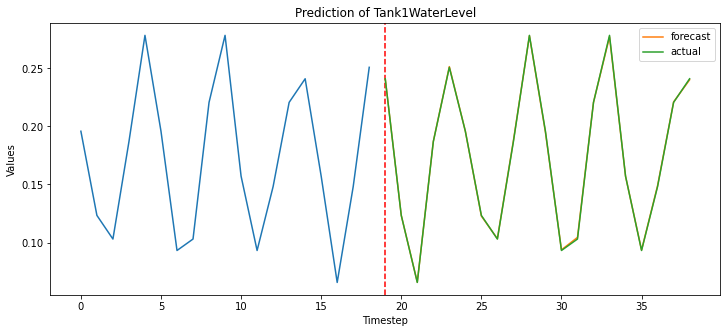

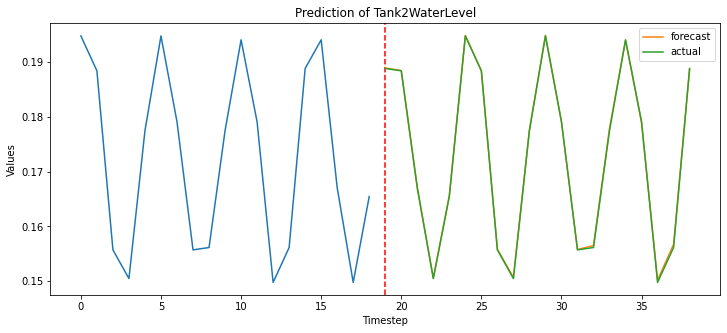

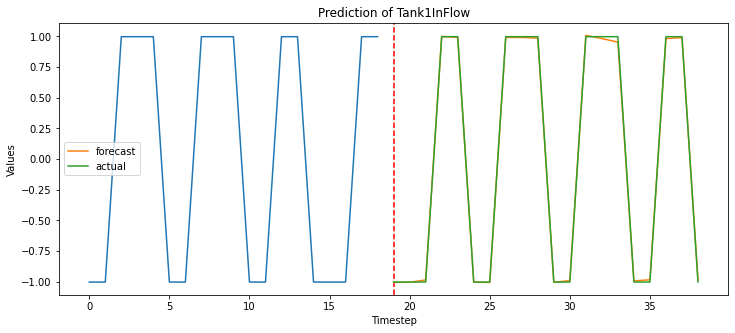

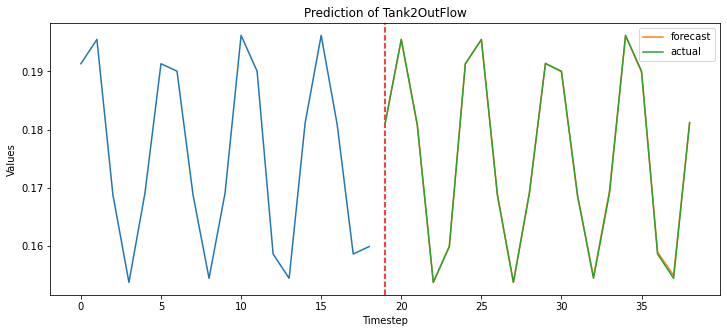

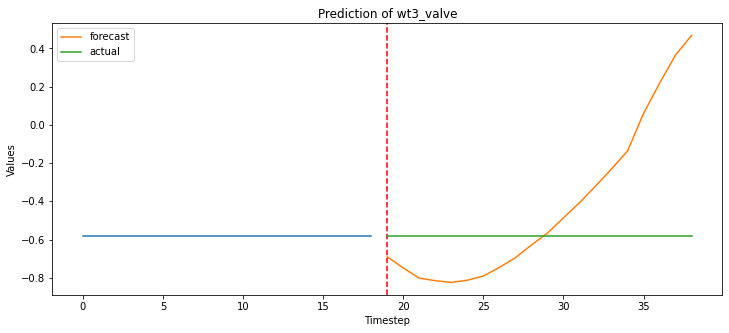

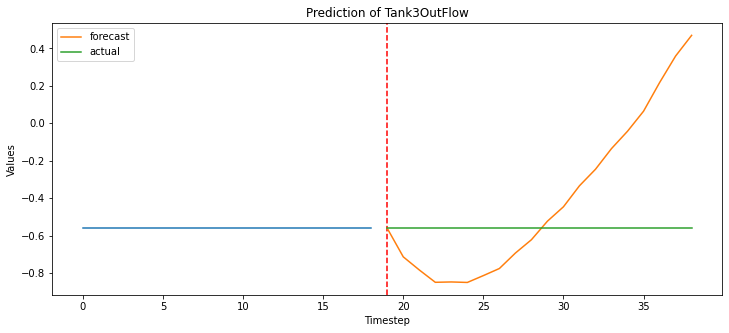

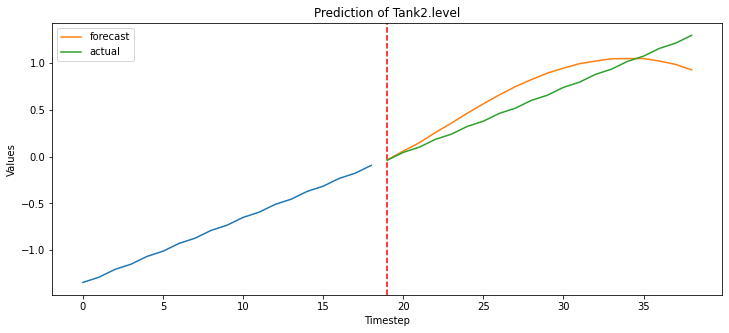

In [330]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

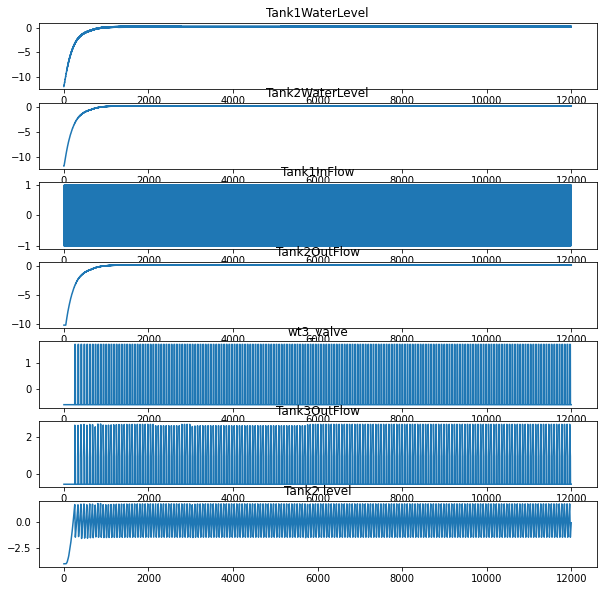

In [331]:
results.plot();

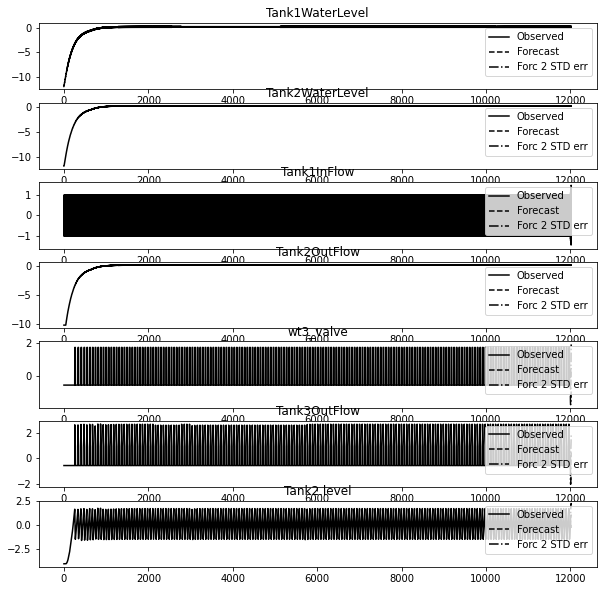

In [332]:
results.plot_forecast(20);

In [333]:
len(df_forecast)

20

### Model Evaluation

In [334]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE)

[11.613344982220699, 11.630335884832935, 1.4714187507740994, 10.318968215627594, 0.4368023469896073, 0.44548788912829695, 4.738308727893677]


### Save the model

In [335]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_golden_model.pkl', 'wb') as f:
    pickle.dump(results.params, f)
print("Model saved!")

Model saved!


### Define the faulty data

In [336]:
# faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# normalised_data, means, stds = normalise_timeseries(faulty_data)
normalised_data = normalise_timeseries(faulty_data)
faulty_data = normalised_data

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

### Load the model and reconstruct VAR

In [337]:
with open('var_golden_model.pkl', 'rb') as f:
    params = pickle.load(f)
    
golden_model = sm.tsa.VAR(train)
golden_model.params = params
golden_model_fit = golden_model.fit(min_aic_index)
# golden_model_fit = golden_model.fit()
golden_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jun, 2023
Time:                     16:23:18
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -66.5238
Nobs:                     11982.0    HQIC:                  -66.9083
Log likelihood:           283936.    FPE:                7.20803e-30
AIC:                     -67.1024    Det(Omega_mle):     6.66817e-30
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.003428         0.000228          -15.039           0.000
L1.Tank1WaterLevel          0.331329         0.010402           31.852           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [338]:
# Use the loaded model to make predictions or perform other analyses
forecast = golden_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[ 0.24182497,  0.18888177, -1.00969009,  0.18109785,  2.79227192,
         2.6901106 ,  3.53990765],
       [ 0.12467408,  0.18859024, -1.02790925,  0.19556324,  3.12967839,
         3.44417943,  3.09280284],
       [ 0.06616195,  0.16731987, -1.04763794,  0.18105579,  3.39621514,
         3.80430154,  2.68565547],
       [ 0.18591294,  0.15072152,  0.93474633,  0.1540385 ,  3.68083113,
         4.05113308,  2.16709437],
       [ 0.25019048,  0.16557448,  0.95375362,  0.1600654 ,  3.9842971 ,
         4.30869762,  1.6901938 ],
       [ 0.19625934,  0.19489873, -1.01541264,  0.19144095,  4.16626714,
         4.52498538,  1.12130548],
       [ 0.12334727,  0.18875711, -1.01990278,  0.19594831,  4.31292847,
         4.58147184,  0.60265257],
       [ 0.10195832,  0.1562569 ,  0.97342653,  0.16959112,  4.37012371,
         4.56467687,  0.03334204],
       [ 0.18628604,  0.15061004,  1.00223182,  0.15428037,  4.4123497 ,
         4.44765614, -0.47605305],
       [ 0.27913399,  0.1774

In [339]:
test_faulty

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
600.05,0.241087,0.188867,-1.001802,0.181157,1.971375,42.089259,3.562841
600.10,0.123358,0.188439,-1.001802,0.195506,1.971375,38.695593,3.236598
600.15,0.065611,0.167089,-1.001802,0.180842,1.971375,36.586616,3.033857
600.20,0.186895,0.150496,0.998202,0.153725,1.971375,33.636728,2.750276
600.25,0.250944,0.165479,0.998202,0.159884,1.971375,31.803492,2.574042
...,...,...,...,...,...,...,...
749.80,0.241088,0.188868,-1.001802,0.181158,-0.507260,-0.199750,-0.435541
749.85,0.157189,0.194102,-1.001802,0.196210,-0.507260,-0.199750,-0.434416
749.90,0.065612,0.167090,-1.001802,0.180843,-0.507260,-0.199750,-0.432726


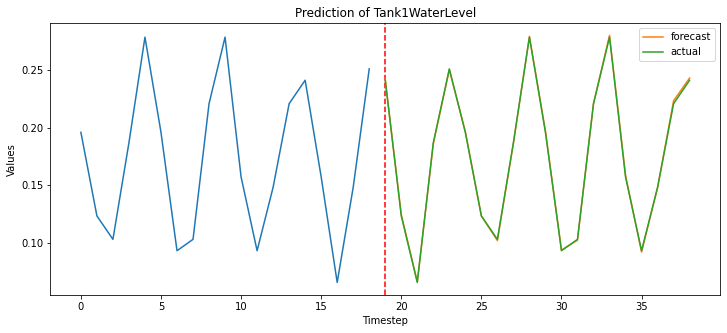

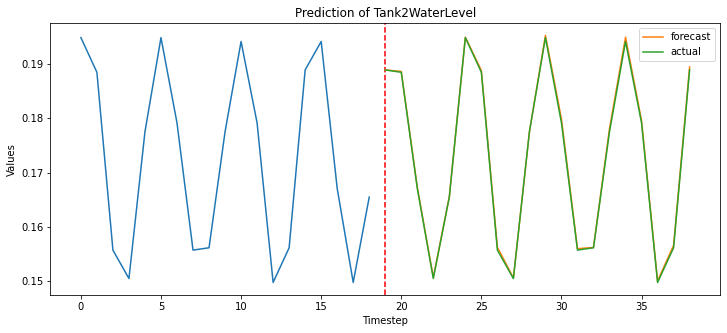

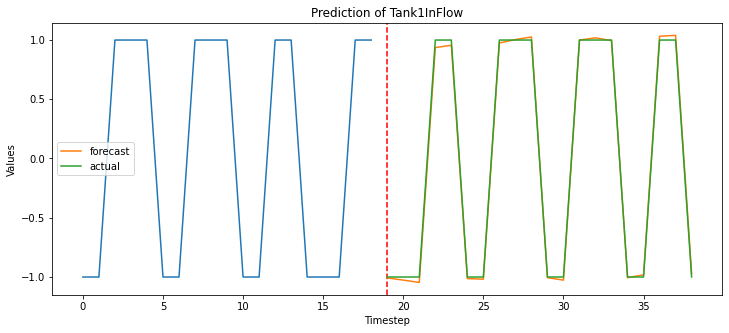

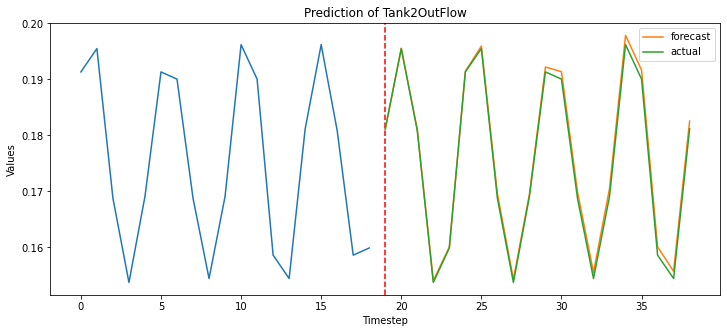

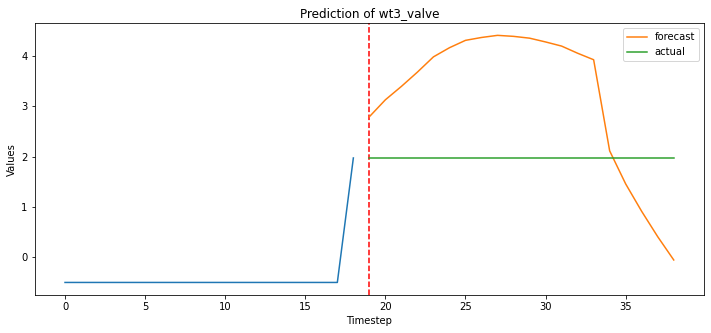

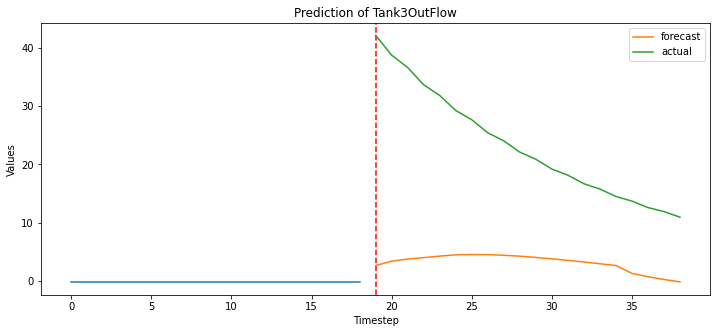

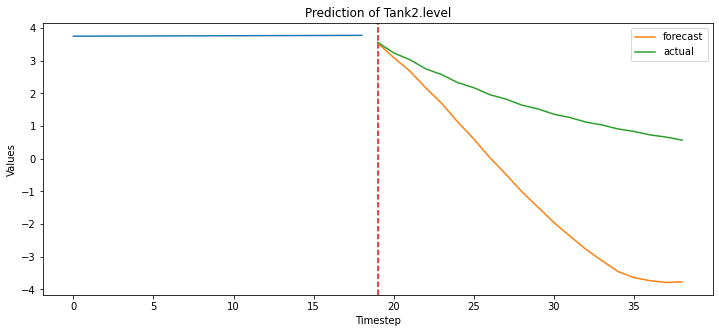

In [340]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [341]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[11.613616584597684, 11.63051985273826, 1.4900749907545987, 10.319724492802166, 4.050926710185545, 4.004017726152734, 4.040586448738246]


Evaluation of the model's performance can be done using the following:
- Accuracy
- Precision
- Recall
- F1 score

### Increasing the duration of faults

In [342]:
df_test_extend = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_test_extend.index.freq = 'MS'
faulty_data_extend = normalise_timeseries(df_test_extend)

# faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# normalised_data_extend, means, stds = normalise_timeseries(faulty_data_extend)
# faulty_data_extend = normalised_data_extend
faulty_data_extend = df_test_extend

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

(12001, 3000)

In [343]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = golden_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

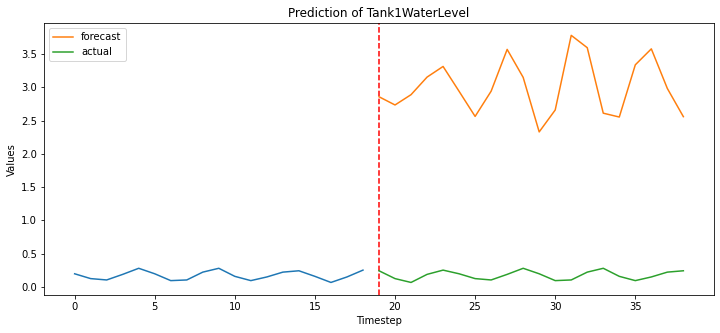

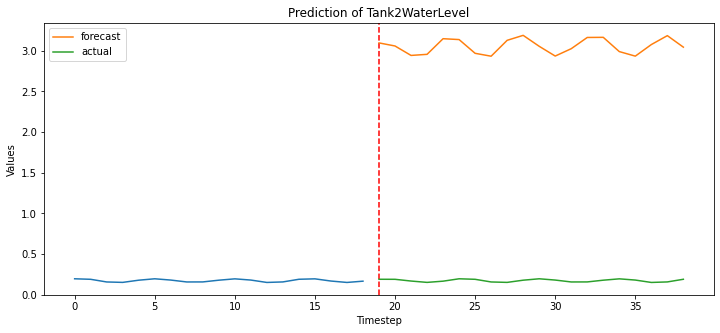

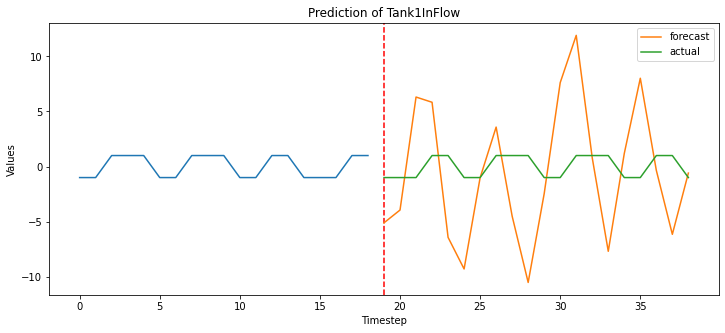

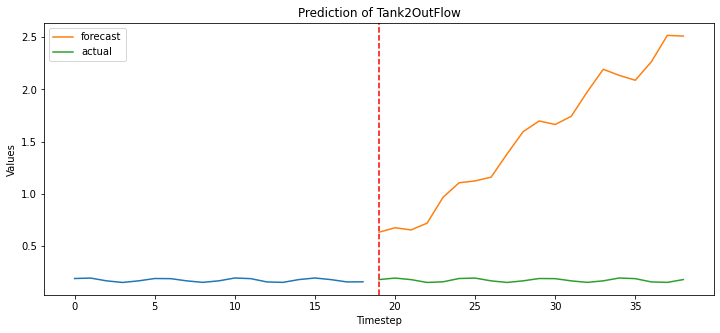

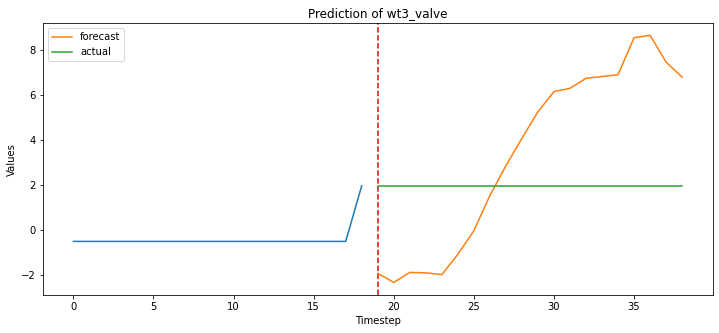

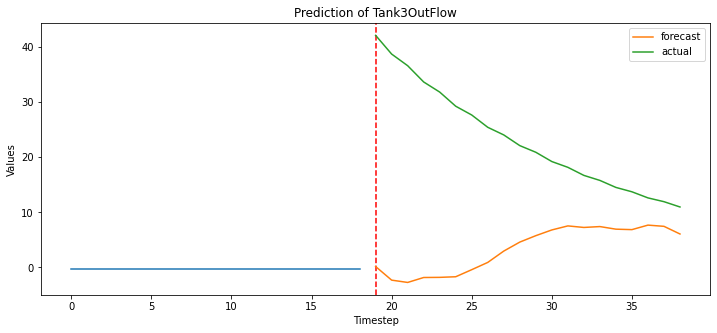

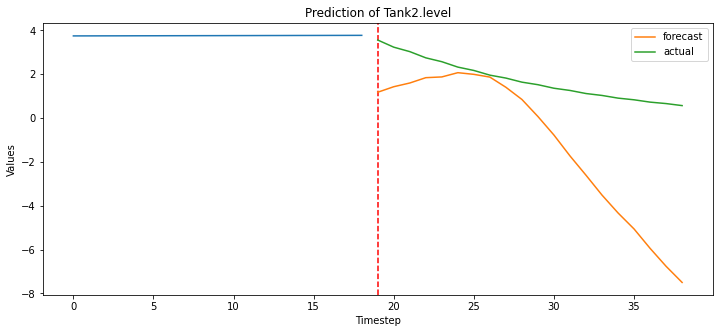

In [344]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast_extend, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [345]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

[14.44535464541214, 14.513736090647352, 5.453743337884772, 11.700978603065906, 5.60692386937008, 5.5954072501715615, 4.350949016176448]


### Fault Detection

In [346]:
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX


<AxesSubplot:xlabel='Time'>

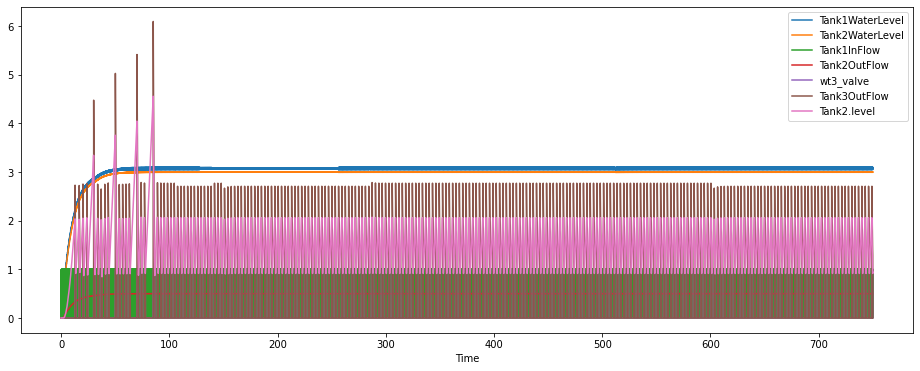

In [347]:
# ndf = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
ndf = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0)
ndf.plot(figsize=(16,6))

In [348]:
# # Train best multivariate model
# var = VAR(fault_forecast)
# var_result = var.fit(min_aic_index)

# var_result.aic

In [349]:
# Compute Train T2 metric (Hotelling's T-squared)
residuals_mean = results.resid.values.mean(axis=0)
residuals_std = results.resid.values.std(axis=0)

residuals = (results.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))
T.shape

(11982,)

In [350]:
# Compute UCL - Upper Control Limit

m = results.nobs
p = results.resid.shape[-1]
alpha = 0.01

# UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL = stats.f.ppf(alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL

1.239571943261128

In [351]:
# Set the UCL
UCL = 500

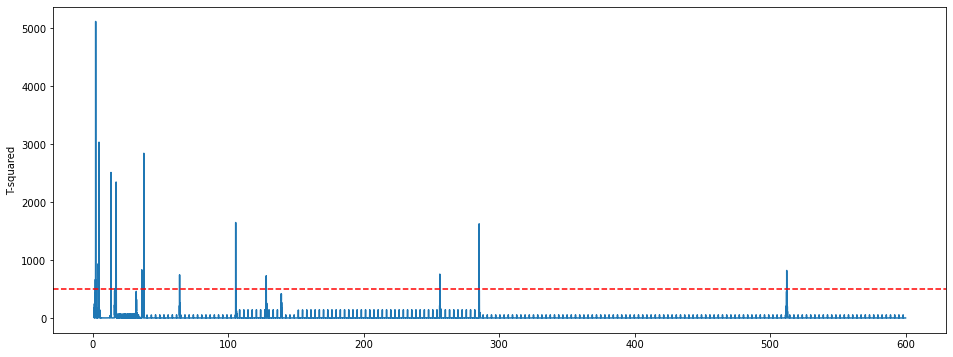

In [352]:
# Plot Train T2 metric

plt.figure(figsize=(16,6))
# plt.plot(train.index[min_aic_index:], T)
plt.plot(train.index[min_aic_index:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [356]:
print("Print")

Print
